## Building load forecasting: Hospital in SF

We can train a forecaster on another commom energy problem. In this, case we are training a 1-step ahead forecaster to predict the electricity consumption of a building.

The dataset contains one year of hourly observations.
The training will occur on 11 months of the data, reserving the last month for evaluation.

In [1]:
if 'google.colab' in str(get_ipython()):
    !pip install git+https://github.com/ourownstory/neural_prophet.git # may take a while
    #!pip install neuralprophet # much faster, but may not have the latest upgrades/bugfixes
    
import pandas as pd
from neuralprophet import NeuralProphet, set_log_level
# set_log_level("ERROR")

In [2]:
# data_location = "https://raw.githubusercontent.com/ourownstory/neuralprophet-data/main/datasets/"
data_location = '../../../neuralprophet-data/datasets/'

sf_load_df = pd.read_csv(data_location +  'energy/SF_hospital_load.csv')

In [3]:
sf_load_df.head(3)

,ds,y
0,2015-01-01 01:00:00,778.007969
1,2015-01-01 02:00:00,776.241750
2,2015-01-01 03:00:00,779.357338


### Generic forecast: Time-based features only
In this first section, we will train a model with time-features only like we would do with Facebook Prophet.

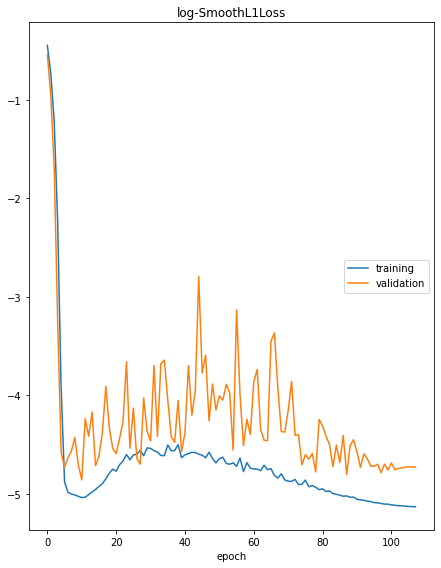

Epoch[108/108]: 100%|█| 108/108 [00:35<00:00,  3.00it/s, SmoothL1Loss=0.0059, MAE=45.7, MSE=4.22e+3, RegLoss=0.000465, MAE_val=54.7, MSE_val=6.32e+3, Sm


In [4]:
m = NeuralProphet(
    weekly_seasonality=6,
    daily_seasonality=10,
    trend_reg=1,
    learning_rate=0.03,
)
df_train, df_test = m.split_df(sf_load_df, freq='H', valid_p = 1.0/12)

metrics = m.fit(df_train, freq='H', validation_df=df_test, plot_live_loss=True)

In [5]:
metrics.tail(1)

,SmoothL1Loss,MAE,MSE,RegLoss,SmoothL1Loss_val,MAE_val,MSE_val
107,0.005904,45.715567,4222.154892,0.000465,0.008836,54.702106,6318.568359


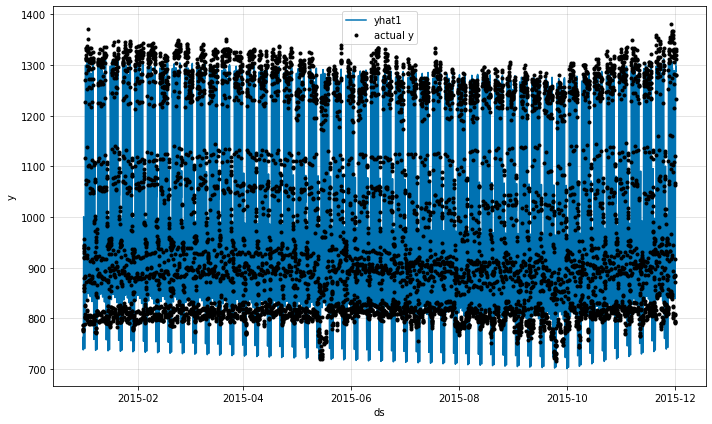

In [6]:
forecast = m.predict(df_train)
fig = m.plot(forecast)

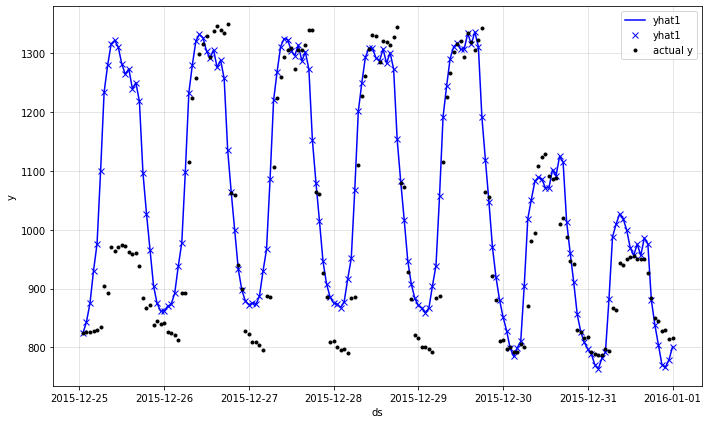

In [7]:
forecast = m.predict(df_test)
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast[-7*24:])

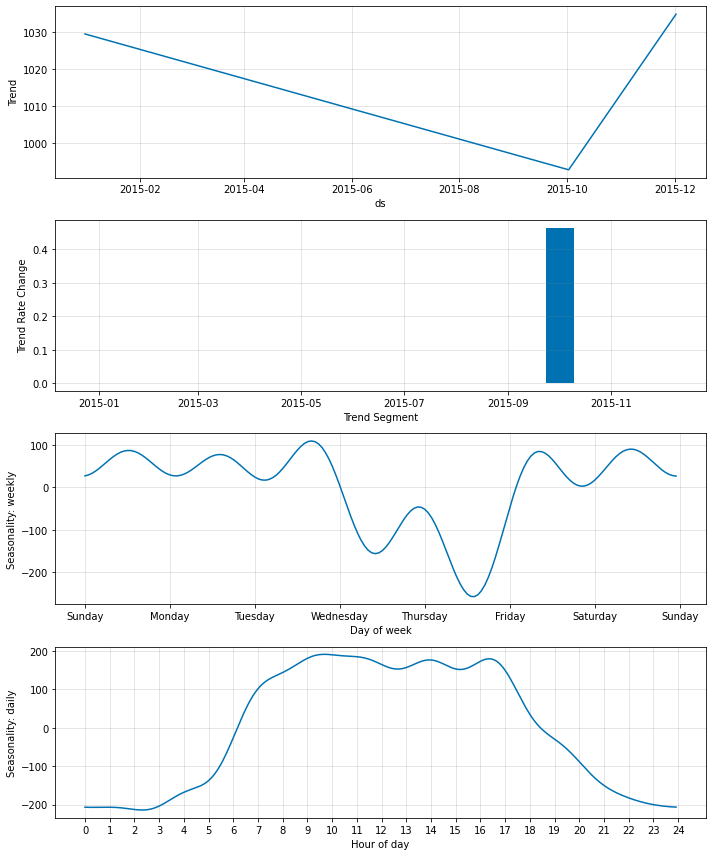

In [8]:
fig_param = m.plot_parameters()

## 1-step ahead forecast with Auto-Regression

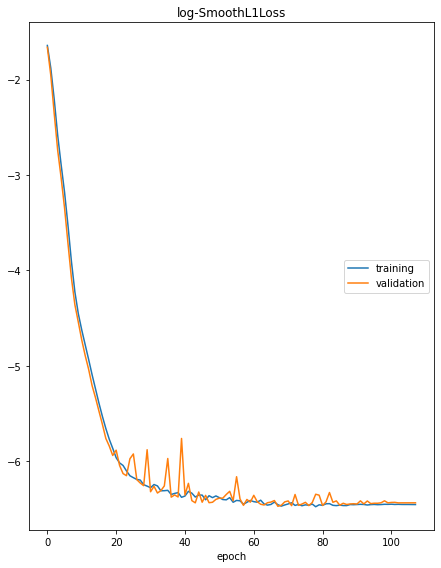

Epoch[108/108]: 100%|█| 108/108 [00:23<00:00,  4.50it/s, SmoothL1Loss=0.00157, MAE=22.1, MSE=1.12e+3, RegLoss=0.00105, MAE_val=22.5, MSE_val=1.15e+3, Sm


In [9]:
m = NeuralProphet(
    growth='off',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=3*24,
    ar_sparsity=0.95,
    learning_rate = 0.003,
)
df_train, df_test = m.split_df(sf_load_df, freq='H', valid_p = 1.0/12)

metrics = m.fit(df_train, freq='H', validation_df=df_test, plot_live_loss=True)

In [10]:
metrics.tail(1)

,SmoothL1Loss,MAE,MSE,RegLoss,SmoothL1Loss_val,MAE_val,MSE_val
107,0.001572,22.054379,1124.66244,0.001046,0.001601,22.483446,1145.440063


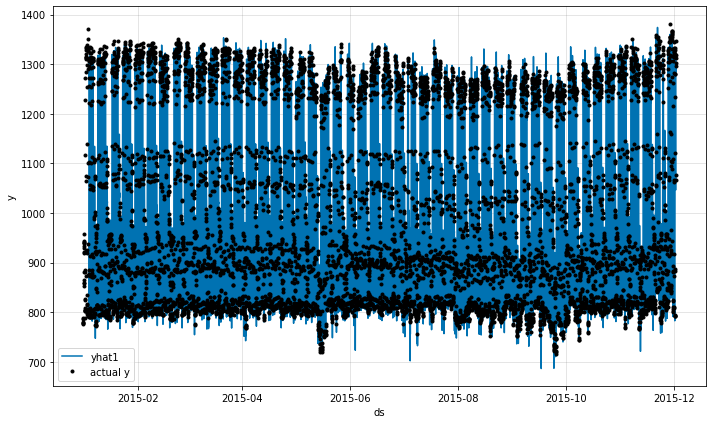

In [11]:
forecast = m.predict(df_train)
fig = m.plot(forecast)

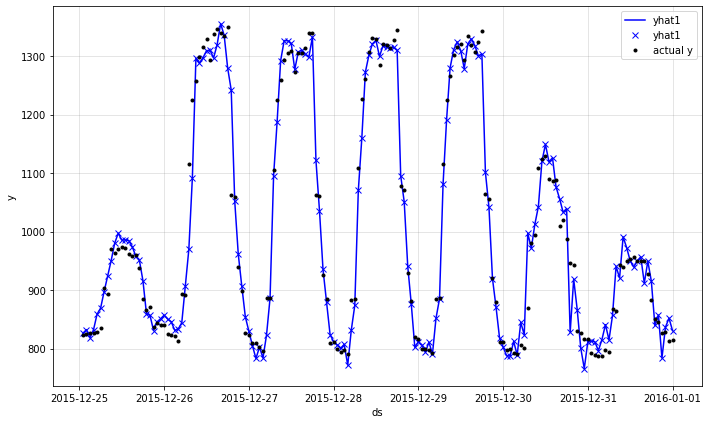

In [12]:
forecast = m.predict(df_test)
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast[-7*24:])

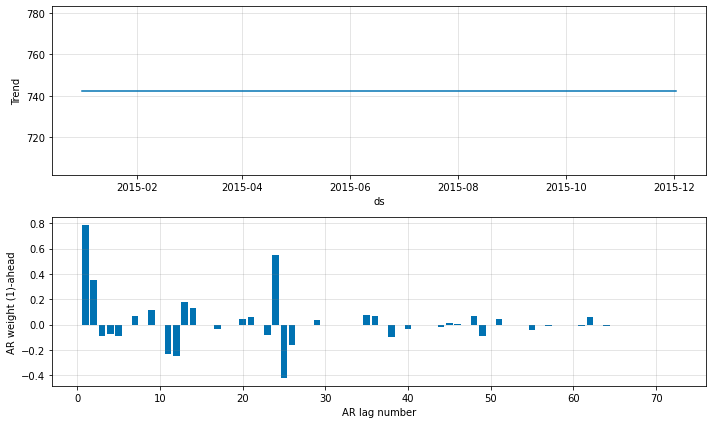

In [13]:
fig_param = m.plot_parameters()

## 1 step ahead forecast with AR-Net: Using a Neural Network
Here, we will use the power of a neural Network to fit non-linear patterns.

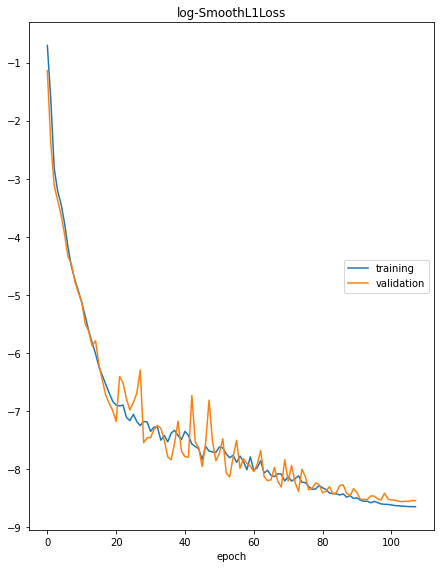

Epoch[108/108]: 100%|█| 108/108 [00:36<00:00,  2.99it/s, SmoothL1Loss=0.000175, MAE=7.68, MSE=125, RegLoss=0, MAE_val=8.15, MSE_val=140, SmoothL1Loss_va


In [14]:
m = NeuralProphet(
    growth='off',
    yearly_seasonality=False,
    weekly_seasonality=False,
    daily_seasonality=False,
    n_lags=3*24,
    num_hidden_layers=4,
    d_hidden=16,
    learning_rate=0.003,
)
df_train, df_test = m.split_df(sf_load_df, freq='H', valid_p = 1.0/12)

metrics = m.fit(df_train, freq='H', validation_df=df_test, plot_live_loss=True)

In [15]:
metrics.tail(1)

,SmoothL1Loss,MAE,MSE,RegLoss,SmoothL1Loss_val,MAE_val,MSE_val
107,0.000175,7.675793,125.486209,0.0,0.000195,8.152453,139.636078


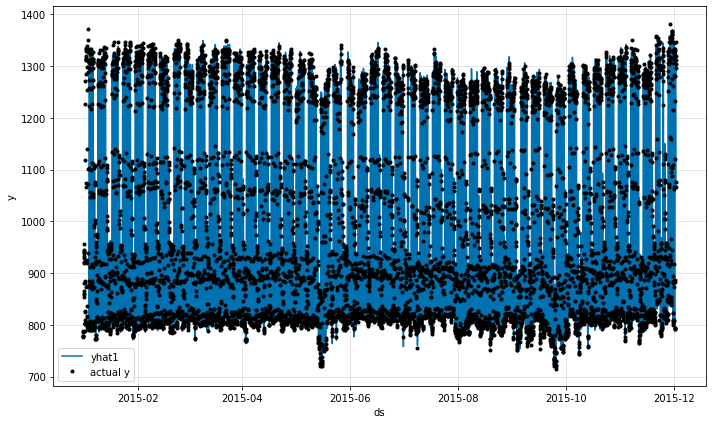

In [16]:
forecast = m.predict(df_train)
fig = m.plot(forecast)

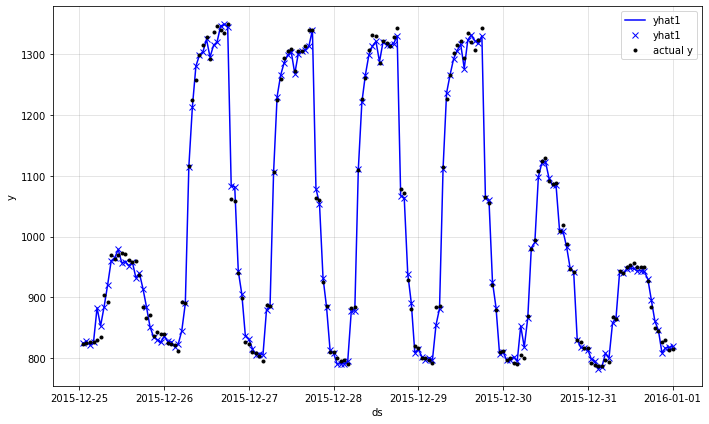

In [17]:
forecast = m.predict(df_test)
m = m.highlight_nth_step_ahead_of_each_forecast(1)
fig = m.plot(forecast[-7*24:])

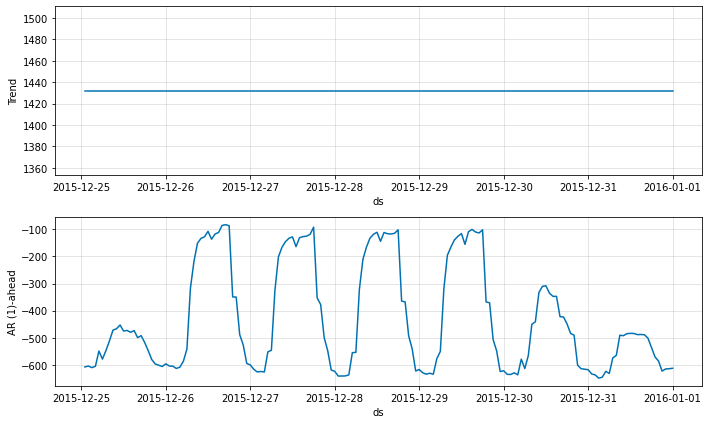

In [18]:
fig_comp = m.plot_components(forecast[-7*24:])